# Quick Start Guide

This guide shows you how to set up and use *scarlet2* to model a hyperspectral image cube. We assume that you have a full installation of _scarlet2_ including `optax`, `numpyro`, and `h5py`. We'll see below where these packages are needed.

In [1]:
# Import Packages and setup
import jax.numpy as jnp
import equinox as eqx
import jax.tree_util
import matplotlib.pyplot as plt
import os
from scarlet2 import *

## Load the Data

We load an example data set (here an image cube from HSC with 5 bands) *and* a detection catalog. If such a catalog is not available, packages like [SEP](http://sep.readthedocs.io/) and [photutils](https://photutils.readthedocs.io/en/stable/) will happily generate one.

To make tests like this one convenient, we have a separate package `scarlet-test-data`, which will automatically be (pip-)installed with the following command:

In [2]:
from tests.utils import import_scarlet_test_data
import_scarlet_test_data()

Then you can load the data set:

In [3]:
from scarlet_test_data import data_path

file = jnp.load(os.path.join(data_path, "hsc_cosmos_35.npz"))
data = jnp.asarray(file["images"])
channels = list(file['filters'])
centers = jnp.array([(src['y'], src['x']) for src in file["catalog"]]) # Note: y/x convention!
weights = jnp.asarray(1/file["variance"])
psf = jnp.asarray(file["psfs"])

```{warning}

Coordinates in *scarlet* are given in the C/numpy notation (y,x) as opposed to the more conventional (x,y) ordering.
```

## Define Model Frame and Observation

A `Frame` in _scarlet2_ is a description of the hyperspectral cube of the model or the observations. Think of it as the metadata, what aspects of the sky are described here. At the least, a `Frame` holds the `shape` of the cube, for which we use the convention `(C, H, W)` for the number of elements in 3 dimensions: `C` for the number of bands/channels and `H/W` for the height and width of the images.

An `Observation` combines a `Frame` with several data units, similar to header-data arrangement in FITS files. In addition to the actual science image cube, you can and often must provide weights for all elements in the data cube, an image cube of the PSF model (one image for all or one for each channel), an `astropy.WCS` structure to translate from pixel to sky coordinates, and labels for all channels. The reason for specifying them is to enable the code to internally map from the model frame, in which you seek to fit a model, to the observed data frame.

```{note}
It is critical to realize that there are two frames: one for model that represents the scene on the sky, and one
 for any observation of that scene. The frames may be identical, but usually they are not, in which case the
observation is a degraded version of the model. The degradation could be in terms of spatial resolution, PSF
blurring, spectral coverage, or all of the above. Choosing model frame and the observation frame as the same
implies that no information has been lost by degradation.
```

In this example, we assume that bands and pixel locations are identical between the model and the observation. Because we have ground-based images, the degradation comes from the PSF. With different PSFs in each band, we need to provide a reference PSF for the model. We simply choose a minimal Gaussian PSF that is barely well-sampled (standard deviation of 0.7 pixels) as our reference kernel:

In [4]:
model_psf = GaussianPSF(0.7)

With this we can fully specify the `Frame` and `Observation`:

In [5]:
model_frame = Frame(Box(data.shape), psf=model_psf, channels=channels)

obs = Observation(data,
                  weights,
                  psf=ArrayPSF(psf),
                  channels=channels,
                  ).match(model_frame)

The last command calls the `match` method to compute, e.g., PSF difference kernels and resampling transformations.

### Display Image Cube

We can now make use of the plotting function `plot.observation` to create a RGB image of our data.
We're going to use a $\mathrm{sinh}^{-1}$ function, which is automatically tuned to reveal both the noise level and the highlights, to normalize the flux in each filter to create a color-consistent RGB image.

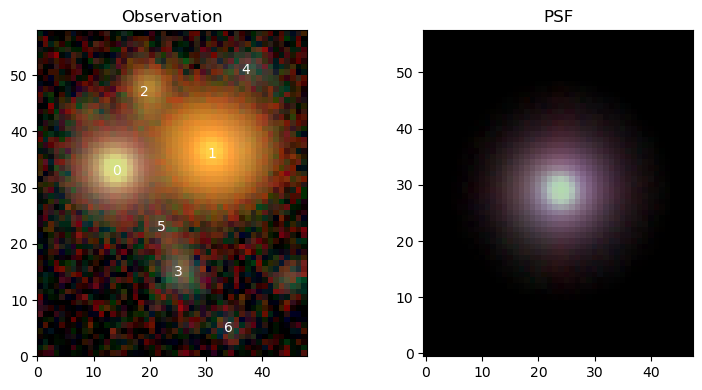

In [6]:
norm = plot.AsinhAutomaticNorm(obs)
plot.observation(obs, norm=norm, sky_coords=centers, show_psf=True, add_labels=True)
plt.show()

Since we use no `wcs` in this `Observation`, all coordinates are already in image pixels, otherwise RA/Dec pairs are expected as `astropy` sky coordinates.

## Initialize Sources

You now need to define sources that are going to be fit. The full model, which we will call `Scene`, is a collection of `Source`s. Each source contains at least one `Component`, and each of those is defined by a `center`, `spectrum`, and `morphology`, and each of these are models with their own parameters. You can have as many sources in a scene, or as many components in a source, as you want. To represent stars or other point sources, we provide the class `PointSource`, which adopts the PSF of the model frame as the morphological model of the source.

To adding sources to a scene is easy. You create the scene (as a python context with the `with` keyword) and then create a source inside of that context. It will automatically be added to the overall scene model. But now we have to decide what the initial values of `spectrum` and `morphology` should be. You can choose them as you see fit, but we also provide convenience methods. For instance `init.pixel_spectrum` takes the spectrum of one pixel (typically the center pixel), and `init.from_gaussian_moments` measures the spectrum and morphology by measuring the 2nd moments and creating an elliptical Gaussian to match those.

In [7]:
with Scene(model_frame) as scene:
    for center in centers:
        try:
            spectrum, morph = init.from_gaussian_moments(obs, center, min_corr=0.99)
        except ValueError:
            spectrum = init.pixel_spectrum(obs, center)
            morph = init.compact_morphology()

        Source(center, spectrum, morph)

If we know something about the scene, we might want to customize the modeling. Let's assume that we know that object 0 is a star. We could just replace that source with a `PointSource`, but for clarity we rebuild the entire source list, making one change for source 0 and accepting everything else from the default initialization above:

In [8]:
with Scene(model_frame) as scene:
    for i, center in enumerate(centers):
        if i == 0: # we know source 0 is a star
            spectrum = init.pixel_spectrum(obs, center)
            PointSource(center, spectrum)
        else:
            try:
                spectrum, morph = init.from_gaussian_moments(obs, center, min_corr=0.99)
            except ValueError:
                spectrum = init.pixel_spectrum(obs, center)
                morph = init.compact_morphology()

            Source(center, spectrum, morph)

We can now check what source we have in `scene`:

In [9]:
print(scene.sources)

[PointSource(
  center=f32[2],
  spectrum=ArraySpectrum(data=f32[5]),
  morphology=GaussianMorphology(size=0.7, ellipticity=None),
  bbox=Box(shape=(5, 7, 7), origin=(0, 30, 11)),
  components=[],
  component_ops=[]
), Source(
  center=f32[2],
  spectrum=ArraySpectrum(data=f32[5]),
  morphology=ArrayMorphology(data=f32[31,31]),
  bbox=Box(shape=(5, 31, 31), origin=(0, 21, 16)),
  components=[],
  component_ops=[]
), Source(
  center=f32[2],
  spectrum=ArraySpectrum(data=f32[5]),
  morphology=ArrayMorphology(data=f32[35,35]),
  bbox=Box(shape=(5, 35, 35), origin=(0, 30, 2)),
  components=[],
  component_ops=[]
), Source(
  center=f32[2],
  spectrum=ArraySpectrum(data=f32[5]),
  morphology=ArrayMorphology(data=f32[13,13]),
  bbox=Box(shape=(5, 13, 13), origin=(0, 9, 19)),
  components=[],
  component_ops=[]
), Source(
  center=f32[2],
  spectrum=ArraySpectrum(data=f32[5]),
  morphology=ArrayMorphology(data=f32[7,7]),
  bbox=Box(shape=(5, 7, 7), origin=(0, 48, 34)),
  components=[],
  com

We can see that the first source is indeed a `PointSource`, while all others are standard `Source`s. The data portions in these models are listed as, e.g., `f32[31,31]`, which denotes an image array of 31x31 pixels. The size of these boxes was determined by `init.from_gaussian_moments` to contain most of the flux (or the largest box that seems to be occuoied by only one source).

## Fit the Model

The `Scene` class holds the list of sources, create a model of the sky, which determines the likelihood of the model:

In [10]:
scene_array = scene() # evaluate the model
print("Initial likelihood:", obs.log_likelihood(scene_array))

Initial likelihood: -3358381.8


You can now write your own fitter or sampler, but we provide the machinery for that as well. We're using `optax` for the optimization. First we need to define which parameters of the model should be optimized. This includes stepsizes and, optionally, differentiable constraints from `numpyro`:

In [11]:
from functools import partial
from numpyro.distributions import constraints
spec_step = partial(relative_step, factor=0.05) # best set size of spectrum parameters

parameters = scene.make_parameters()
for i in range(len(scene.sources)):
    parameters += Parameter(scene.sources[i].spectrum.data,
                            name=f"spectrum:{i}",
                            constraint=constraints.positive,
                            stepsize=spec_step)
    if i == 0:
        parameters += Parameter(scene.sources[i].center,
                                name=f"center:{i}",
                                stepsize=0.1)
    else:
        parameters += Parameter(scene.sources[i].morphology.data,
                                name=f"morph:{i}",
                                constraint=constraints.positive,
                                stepsize=0.1)

A model parameter that is not listed in `parameters` will not be updated. Now we can run the fitting method, and update every one of the `parameters`. We give ourselves a head-start by first running a linear solver for the spectra given the shapes of every source:

In [12]:
maxiter = 200
scene.set_spectra_to_match(obs, parameters)
scene_ = scene.fit(obs, parameters, max_iter=maxiter, e_rel=1e-4, progress_bar=False)

100%|██████████| 200/200 [00:01<00:00, 136.16it/s, loss=21346.34, max_change=0.007132]


## Interact with Results

The updated source models are now available in `scene_`. We can evaluate the entire scene and compute the now improved likelihood:

In [13]:
scene_array = scene_()
print("Optimized likelihood:",obs.log_likelihood(scene_array))

Optimized likelihood: -21373.777


### Display Full Scene

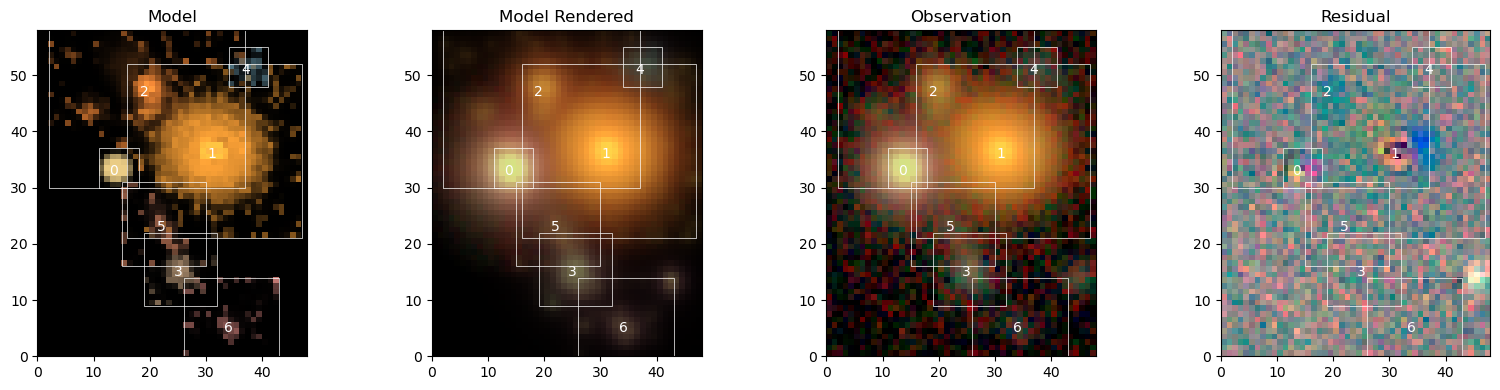

In [47]:
plot.scene(scene_,
           obs,
           norm=norm,
           show_model=True,
           show_rendered=True,
           show_observed=True,
           show_residual=True,
           add_boxes=True,
           )
plt.show()

The fit is overall quite good, with low residuals, but it's not perfect. Let's investigate...

### Access All Sources

Individual sources can be accessed and evaluated as well, but we have to decide in which frame we want to see them. There are three options:


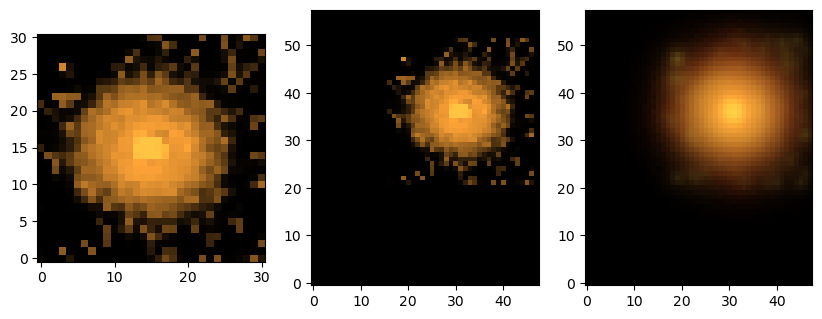

In [15]:
# Get models for source 1
source = scene_.sources[1]
# in its own source box (indicated by the white boxes in the figure above)
source_array = source()
# inserted in model frame
source_in_scene_array = scene_.evaluate_source(source)
# as it appears in observed frame
source_as_seen = obs.render(source_in_scene_array)

fig, axes = plt.subplots(1, 3, figsize=(10,4))
axes[0].imshow(plot.img_to_rgb(source_array, norm=norm))
axes[1].imshow(plot.img_to_rgb(source_in_scene_array, norm=norm))
axes[2].imshow(plot.img_to_rgb(source_as_seen, norm=norm))
plt.show()

We also provide a function to create all of these source images:

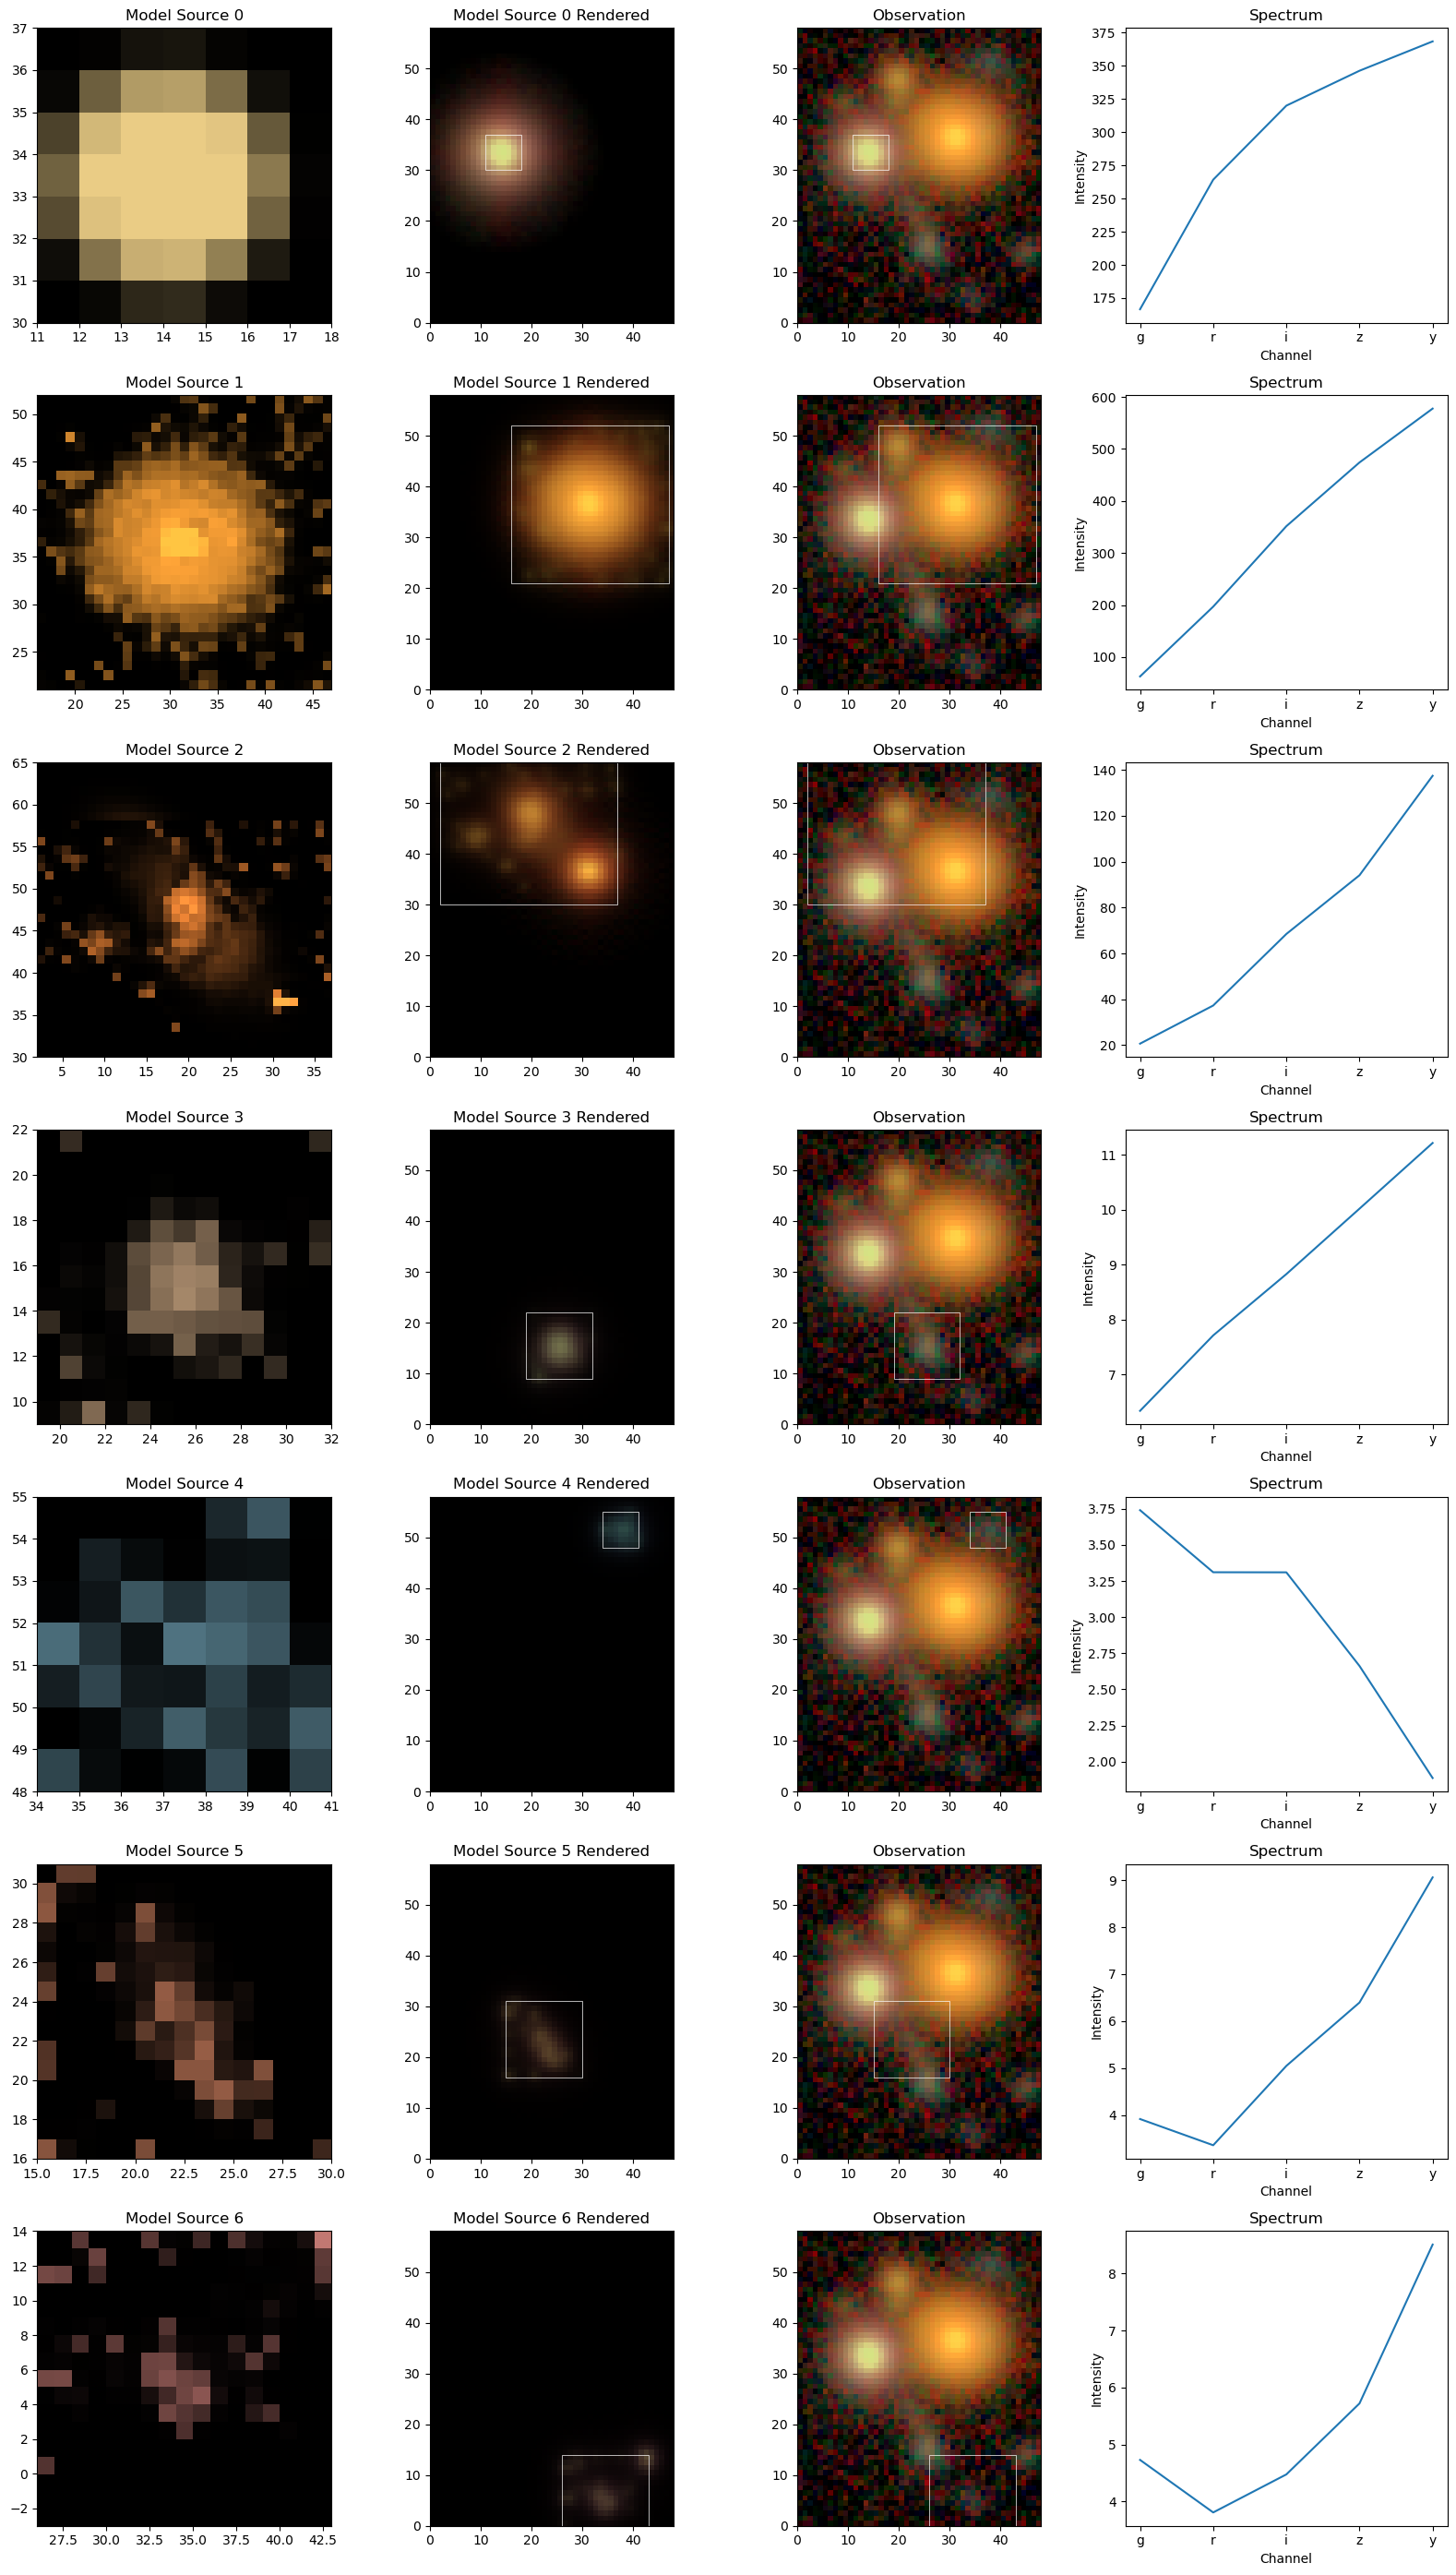

In [16]:
plot.sources(scene_,
             norm=norm,
             observation=obs,
             show_model=True,
             show_rendered=True,
             show_observed=True,
             show_spectrum=True,
             add_markers=False,
             add_boxes=True,
)
plt.show()

We can see that each source "lives" in a smaller box and is then placed into the larger scene. The model of object 0 assumes the simple Gaussian shape of the model PSF, which is the internal representation of a point source.

It's noticeable that all other sources, however, show pixel patterns that don't seem right. Some of them follow other sources (especially source 2) or noise (sources 4-6). What we see here is the limitation of non-parametric models: they can fit anything, but the likelihood may not have enough information to constrain all of these degrees of freedom. More/stronger constraints or priors can help, and we will describe their use in [a separate tutorial](tutorials/priors).

### Source Measurements

As shown above, source models are generated in the model frame (which is the best-fit representation of the full hyperspectral `Frame`), from which any measurement can directly be made without having to deal with noise, PSF convolution, overlapping sources, etc.

For instance, the color information in these plots stems from the spectrum, i.e. the per-band amplitude, which are computed from the hyperspectral model by integrating over the morphology. The source spectra plots in the right panels above have done exactly that. The convention of these fluxes is given by the units and ordering of the original data cube.

In [17]:
print ("----------------- {}".format(channels))
for k, src in enumerate(scene_.sources):
    print ("Source {}, Fluxes: {}".format(k, measure.flux(src)))

----------------- ['g', 'r', 'i', 'z', 'y']
Source 0, Fluxes: [166.57903 264.2223  320.00674 346.30078 368.42587]
Source 1, Fluxes: [ 62.873302 197.0117   351.57227  474.07944  577.58075 ]
Source 2, Fluxes: [ 20.647808  37.27663   68.47661   94.09483  137.48074 ]
Source 3, Fluxes: [ 6.3413734  7.713371   8.828495  10.018554  11.2131815]
Source 4, Fluxes: [3.7403998 3.3108535 3.310309  2.6624408 1.8868122]
Source 5, Fluxes: [3.9180825 3.3606796 5.048596  6.3960676 9.057995 ]
Source 6, Fluxes: [4.7303004 3.808729  4.4759245 5.721491  8.509052 ]


Other measurements (e.g. `centroid`) or `Moments` are also implemented:

In [18]:
g = measure.Moments(scene_.sources[1])
print("Source 1 ellipticity:", g.ellipticity)

Source 1 ellipticity: [[ 0.06358338  0.0635836   0.06358343  0.06358359  0.06358304]
 [-0.02847458 -0.02847456 -0.02847455 -0.0284746  -0.02847456]]


All of these measurements are ordered by channel, so the ellipticity above is listed as `[[e1_g, e1_r, e1_i, e1_z, e1_y],[e2_g, e2_r, e2_i, e2_z, e2_y]]`. That they are all the same should not come as a surprise: For single-component models, there is no variation of the morphology across the channels.

### Save and Re-Use Model

To preserve the model for posterity, individual sources (or their sub-models) or entire scenes can be serialized into a HDF5 file:

In [20]:
import scarlet2.io

id = 35
filename = "hsc_cosmos.h5"
scarlet2.io.model_to_h5(scene_, filename, id=id, overwrite=True)

The stored model be loaded in the same way. Every source can be utilized as before.

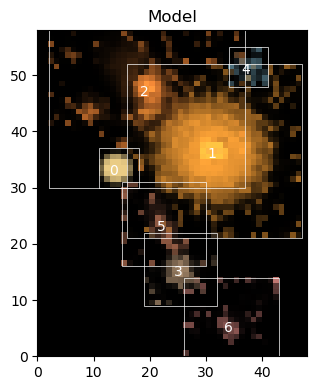

In [42]:
scene__ = scarlet2.io.model_from_h5(filename, id=id)
plot.scene(scene__, observation=obs, norm=norm, add_boxes=True)
plt.show()

We will now add two more sources to account for the largest residuals we have seen above. As we don't know their location accurately, we allow the fitter to shift/recenter the sources.

In [43]:
# enter the context of the scene to create new elements
with scene__:
    # add two marginally detected sources at their approximate locations
    yx = [(14., 44.), (42., 9.), centers[1]]
    for center in yx:
        center = jnp.array(center)
        spectrum = init.pixel_spectrum(obs, center)
        morph = init.compact_morphology()
        Source(center, spectrum, morph)

# need to remake the parameter structure because we have more free parameters now
parameters__ = scene__.make_parameters()
for i in range(len(scene__.sources)):
    parameters__ += Parameter(scene__.sources[i].spectrum.data,
                              name=f"spectrum:{i}",
                              constraint=constraints.positive,
                              stepsize=spec_step)
    if i == 0:
        parameters__ += Parameter(scene__.sources[i].center,
                                  name=f"center:{i}",
                                  stepsize=0.1)
    else:
        parameters__ += Parameter(scene__.sources[i].morphology.data,
                                  name=f"morph:{i}",
                                  constraint=constraints.positive,
                                  stepsize=0.1)

scene___ = scene__.fit(obs, parameters__, max_iter=maxiter, e_rel=1e-4, progress_bar=False)

100%|██████████| 200/200 [00:01<00:00, 106.03it/s, loss=20382.58, max_change=0.002481]


We can see that logL is slightly better than before. Let's have a look at the new model:

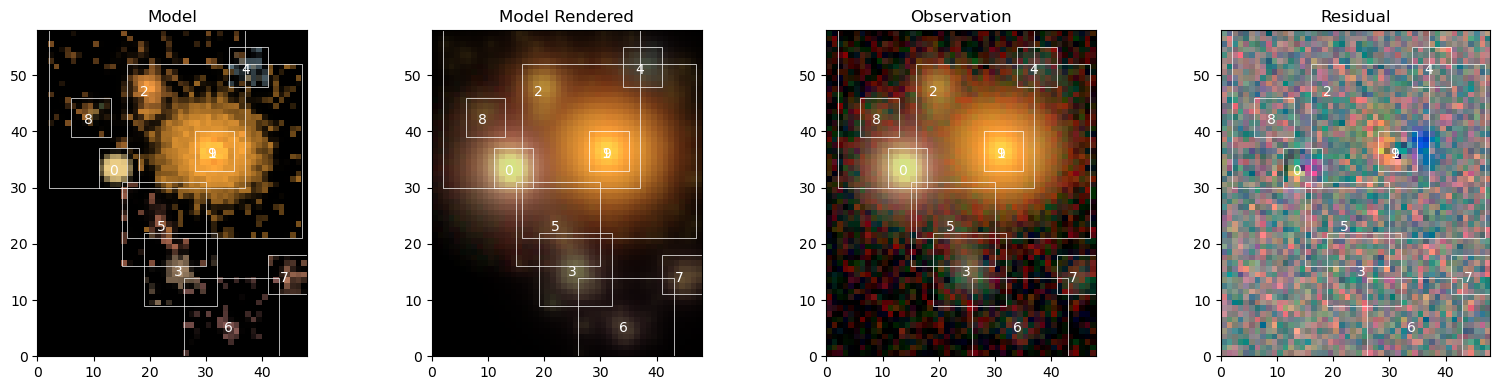

In [44]:
plot.scene(scene___,
           obs,
           norm=norm,
           show_model=True,
           show_rendered=True,
           show_observed=True,
           show_residual=True,
           add_boxes=True
           )
plt.show()

We can see the two new sources 7 and 8, and that most of the other features are very similar to before. As expected, the residuals have visibly improved where we added the source and are now dominated by a red-blue pattern in the center of source 1, which we should probably fit with 2 components.